# **ECG Data Preprocessing & Exploratory**

**Imports**

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import seaborn as sns
import io
from scipy.stats import zscore
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

**ECG Filter Showcase: Step-by-Step Baseline, Notch & Band-Pass Processing with Lead-to-Lead Visual Comparisons**


In [ ]:
# Define input/output
input_file = "drive/MyDrive/ECGData/MUSE_20180210_123404_25000.csv"
output_base_dir = "drive/MyDrive/ECGFiltersOutput"
os.makedirs(output_base_dir, exist_ok=True)

# Filter utilities
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def notch_filter(signal, freq=50.0, fs=500, quality=30):
    b, a = iirnotch(freq / (0.5 * fs), Q=quality)
    return filtfilt(b, a, signal, axis=0)

def remove_baseline_wander(signal, fs=500):
    b, a = butter(2, 0.5 / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal, axis=0)

def butter_bandpass_filter(signal, fs=500):
    b, a = butter_bandpass(0.5, 45, fs)
    return filtfilt(b, a, signal, axis=0)

# Load file
df = pd.read_csv(input_file, header=None)
df = df.iloc[1:].reset_index(drop=True)  # Drop possible header row
df = df.apply(pd.to_numeric, errors='coerce')

if df.shape != (5000, 12) or df.isnull().values.any():
    raise ValueError("Input file must be 5000x12 and contain only numeric data.")

data = df.values

# Apply each filter individually
baseline_removed = remove_baseline_wander(data)
notch_filtered = notch_filter(data)
bandpassed = butter_bandpass_filter(data)

# Apply all filters sequentially
full_filtered = butter_bandpass_filter(notch_filter(remove_baseline_wander(data)))

# Save each version
np.savetxt(os.path.join(output_base_dir, "baseline_removed.csv"), baseline_removed, delimiter=",")
np.savetxt(os.path.join(output_base_dir, "notch_filtered.csv"), notch_filtered, delimiter=",")
np.savetxt(os.path.join(output_base_dir, "bandpassed.csv"), bandpassed, delimiter=",")
np.savetxt(os.path.join(output_base_dir, "fully_filtered.csv"), full_filtered, delimiter=",")

print("All filtered versions saved to:", output_base_dir)
# Leads to plot
leads = [0, 1, 2]  # Lead I, II, III
t = np.arange(5000)

# Titles and data for each filtering stage
filters = [
    ("Baseline Removed", baseline_removed, "baseline_removed_vs_raw.png"),
    ("Notch Filtered", notch_filtered, "notch_filtered_vs_raw.png"),
    ("Bandpassed", bandpassed, "bandpassed_vs_raw.png"),
    ("Fully Filtered (All Combined)", full_filtered, "fully_filtered_vs_raw.png")
]

# Generate and save plots
for title, filtered_data, filename in filters:
    fig, axs = plt.subplots(len(leads), 1, figsize=(14, 10), sharex=True)

    for i, lead in enumerate(leads):
        axs[i].plot(t, data[:, lead], label="Raw", linestyle="--", alpha=0.6)
        axs[i].plot(t, filtered_data[:, lead], label=title, linewidth=1.5)
        axs[i].set_title(f"Lead {lead + 1}: Raw vs. {title}")
        axs[i].set_ylabel("Amplitude")
        axs[i].legend()
        axs[i].grid(True)

    axs[-1].set_xlabel("Time (samples)")
    plt.tight_layout()

    save_path = os.path.join(output_base_dir, filename)
    plt.savefig(save_path)
    print(f"Saved: {save_path}")
    plt.close()



All filtered versions saved to: drive/MyDrive/ECGFiltersOutput
Saved: drive/MyDrive/ECGFiltersOutput/baseline_removed_vs_raw.png
Saved: drive/MyDrive/ECGFiltersOutput/notch_filtered_vs_raw.png
Saved: drive/MyDrive/ECGFiltersOutput/bandpassed_vs_raw.png
Saved: drive/MyDrive/ECGFiltersOutput/fully_filtered_vs_raw.png


**ECG Preprocessing Pipeline: Header Stripping, Quality Validation & Signal Denoising**

In [1]:
# Directory setup
input_dir = "drive/MyDrive/ECGData"
output_dir = "drive/MyDrive/ECGDataDenoised"
bad_files_dir = "drive/MyDrive/bad_files"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(bad_files_dir, exist_ok=True)

# Filter utilities
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def notch_filter(signal, freq=50.0, fs=500, quality=30):
    # Powerline interference
    b, a = iirnotch(w0=freq / (0.5 * fs), Q=quality)
    return filtfilt(b, a, signal, axis=0)

def remove_baseline_wander(signal, fs=500):
    # High-pass filter with ~0.5 Hz cutoff
    b, a = butter(2, 0.5 / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal, axis=0)

def full_denoise_pipeline(raw_signal, fs=500):
    # 1. Remove baseline wander
    baseline_removed = remove_baseline_wander(raw_signal, fs=fs)

    # 2. Notch filter at 50 Hz (or 60 depending on your location)
    notch_cleaned = notch_filter(baseline_removed, freq=50, fs=fs)

    # 3. Bandpass to limit muscle noise and motion artifacts (0.5–45 Hz)
    b, a = butter_bandpass(0.5, 45, fs)
    clean_signal = filtfilt(b, a, notch_cleaned, axis=0)

    return clean_signal

# Process each file
file_list = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for filename in tqdm(file_list, desc="Advanced ECG Denoising"):
    file_path = os.path.join(input_dir, filename)
    try:
        # Read raw CSV (no header)
        df = pd.read_csv(file_path, header=None, na_values=["", " ", "NaN", "nan", "NAN"])

        # Drop first row regardless of content (to remove hidden header)
        df = df.iloc[1:].reset_index(drop=True)

        # Shape check *before* numeric coercion
        if df.shape != (5000, 12):
            raise ValueError(f"Invalid shape: {df.shape}")

        # Force numeric – but keep NaNs so we can detect them
        df = df.apply(pd.to_numeric, errors='coerce')

        # Validate numbers
        dead_lead = (df.std(axis=0) == 0) | df.isnull().all()
        if dead_lead.any():
            raise ValueError("NaN")

        # Apply advanced denoising
        denoised = full_denoise_pipeline(df.values)

        # Save cleaned file
        output_path = os.path.join(output_dir, filename)
        pd.DataFrame(denoised).to_csv(output_path, index=False, header=False)

    except Exception as e:
        print(f"[BAD FILE] {filename} — {e}")
        shutil.copy(file_path, os.path.join(bad_files_dir, filename))


Advanced ECG Denoising:   2%|▏         | 251/10707 [01:04<24:50,  7.01it/s]

[BAD FILE] MUSE_20180210_130454_71000.csv — NaN


Advanced ECG Denoising:   3%|▎         | 309/10707 [01:15<28:40,  6.04it/s]

[BAD FILE] MUSE_20180712_151357_86000.csv — NaN


Advanced ECG Denoising:   4%|▎         | 397/10707 [01:37<26:37,  6.45it/s]

[BAD FILE] MUSE_20180712_152014_31000.csv — NaN


Advanced ECG Denoising:   4%|▍         | 452/10707 [01:48<30:30,  5.60it/s]

[BAD FILE] MUSE_20180712_152019_73000.csv — NaN


Advanced ECG Denoising:   5%|▍         | 520/10707 [02:02<56:05,  3.03it/s]

[BAD FILE] MUSE_20180712_153140_95000.csv — NaN


Advanced ECG Denoising:   6%|▌         | 622/10707 [02:25<46:12,  3.64it/s]

[BAD FILE] MUSE_20180712_152024_00000.csv — NaN


Advanced ECG Denoising:   6%|▌         | 626/10707 [02:26<35:25,  4.74it/s]

[BAD FILE] MUSE_20180712_152114_47000.csv — NaN


Advanced ECG Denoising:   6%|▌         | 656/10707 [02:31<28:44,  5.83it/s]

[BAD FILE] MUSE_20180712_152022_92000.csv — NaN


Advanced ECG Denoising:   6%|▋         | 674/10707 [02:34<24:24,  6.85it/s]

[BAD FILE] MUSE_20180712_151351_36000.csv — NaN


Advanced ECG Denoising:   6%|▋         | 691/10707 [02:38<52:35,  3.17it/s]

[BAD FILE] MUSE_20180712_151353_58000.csv — NaN


Advanced ECG Denoising:   7%|▋         | 779/10707 [02:55<24:17,  6.81it/s]

[BAD FILE] MUSE_20180712_153632_30000.csv — NaN


Advanced ECG Denoising:  19%|█▉        | 2021/10707 [08:14<21:43,  6.66it/s]

[BAD FILE] MUSE_20180119_174843_24000.csv — NaN


Advanced ECG Denoising:  22%|██▏       | 2388/10707 [09:30<25:59,  5.33it/s]

[BAD FILE] MUSE_20180120_121805_89000.csv — NaN


Advanced ECG Denoising:  58%|█████▊    | 6212/10707 [23:32<11:01,  6.79it/s]

[BAD FILE] MUSE_20180114_124230_39000.csv — NaN


Advanced ECG Denoising:  66%|██████▋   | 7119/10707 [27:25<16:07,  3.71it/s]

[BAD FILE] MUSE_20180113_180425_75000.csv — NaN


Advanced ECG Denoising:  73%|███████▎  | 7830/10707 [31:35<08:41,  5.52it/s]

[BAD FILE] MUSE_20180114_080214_06000.csv — NaN


Advanced ECG Denoising:  84%|████████▍ | 8983/10707 [35:31<04:05,  7.03it/s]

[BAD FILE] MUSE_20180113_181145_89000.csv — NaN


Advanced ECG Denoising: 100%|██████████| 10707/10707 [41:24<00:00,  4.31it/s]


**Visual Validation: Side-by-Side ECG Lead Comparison Before & After Denoising**

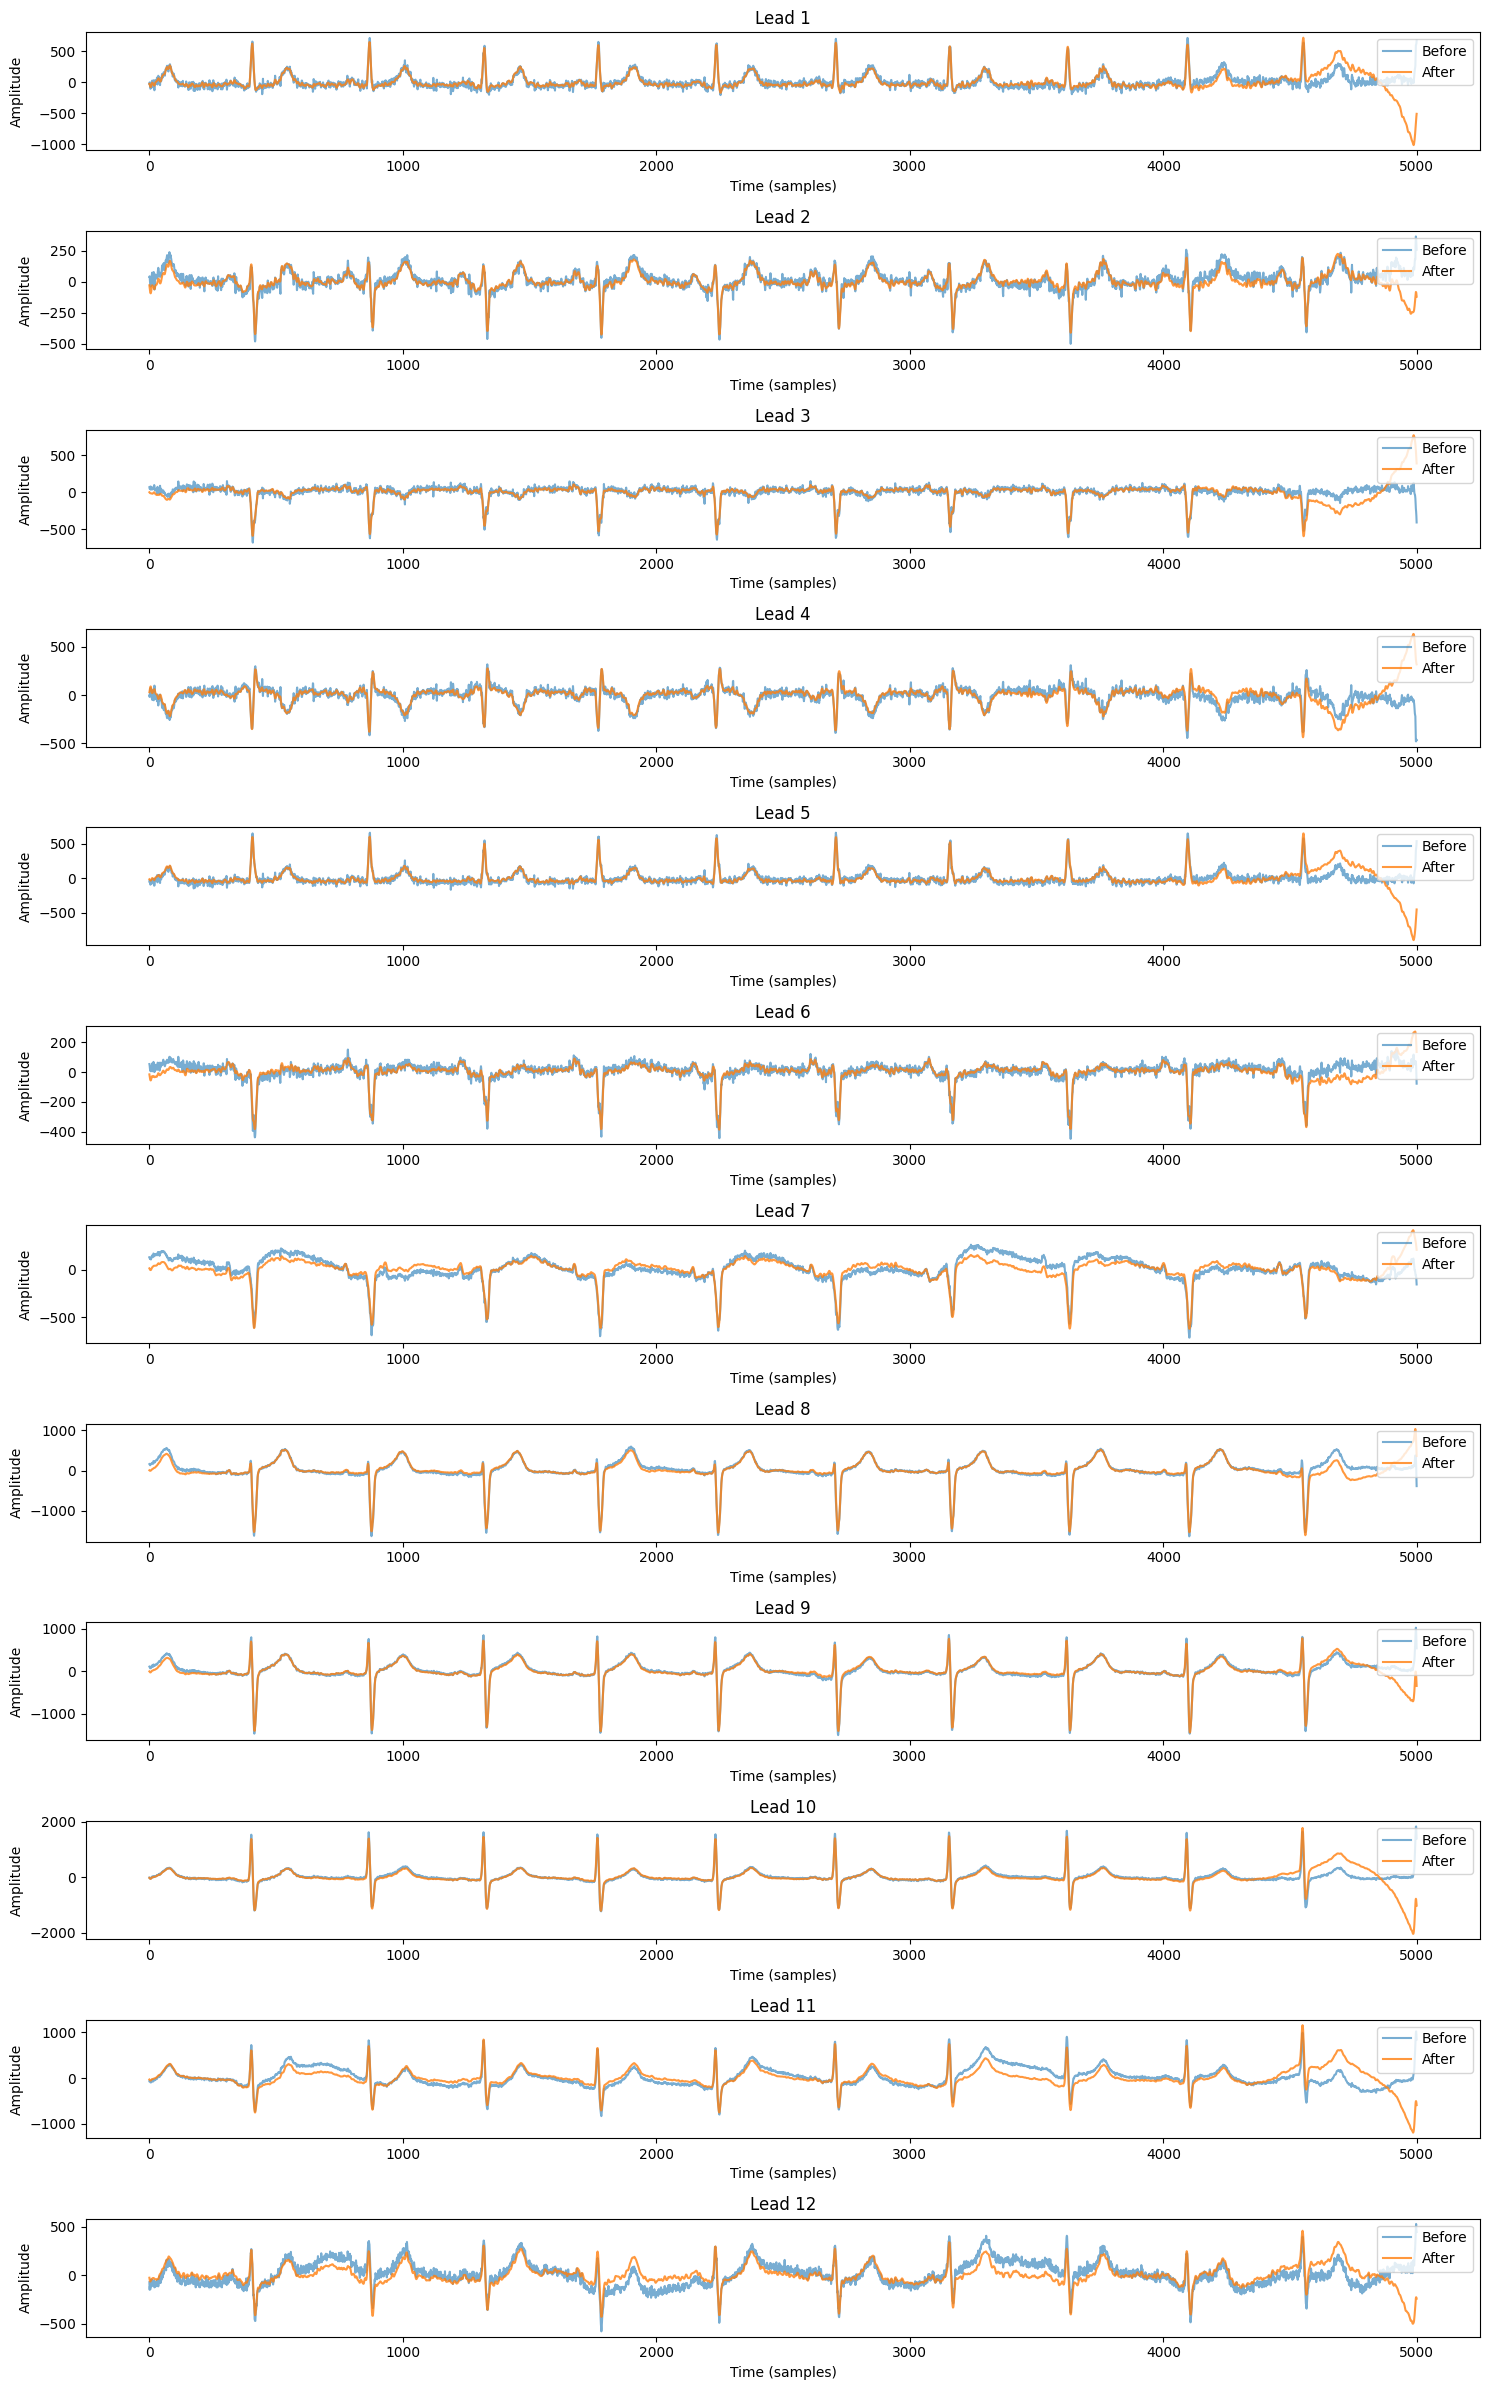

In [ ]:
def plot_ecg_before_after(filename, raw_dir="drive/MyDrive/ECGData", denoised_dir="drive/MyDrive/ECGDataDenoised", leads=[0, 1, 2]):
    """
    Plot selected ECG leads before and after denoising.

    Args:
        filename (str): ECG file name (e.g., 'MUSE_20180111_155115_19000.csv')
        raw_dir (str): Path to original/raw ECGs
        denoised_dir (str): Path to denoised ECGs
        leads (list): List of integer lead indices (0-11)
    """
    # Load files
    raw_path = os.path.join(raw_dir, filename)
    denoised_path = os.path.join(denoised_dir, filename)

    # Read and drop the first row from raw
    raw = pd.read_csv(raw_path, header=None)
    raw = raw.iloc[1:].reset_index(drop=True)
    raw = raw.apply(pd.to_numeric, errors='coerce')

    # Read denoised
    denoised = pd.read_csv(denoised_path, header=None)

    # Time axis
    t = range(5000)

    # Plot
    plt.figure(figsize=(15, len(leads) * 2))
    for i, lead in enumerate(leads):
        plt.subplot(len(leads), 1, i + 1)
        plt.plot(t, raw[lead], label="Before", alpha=0.6)
        plt.plot(t, denoised[lead], label="After", alpha=0.8)
        plt.title(f"Lead {lead + 1}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


plot_ecg_before_after("MUSE_20180210_123404_25000.csv", leads=[0, 1, 2, 3, 4, 5])

 **ECG Exploratory Data Anaylsis: Data Audit, Class Balance & Feature Insights**

In [4]:
def explore_dataset(diagnostics_path, output_dir):
    # Load the dataset
    diagnostics_df = pd.read_csv(diagnostics_path)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Basic data overview
    info_str = []
    buffer = io.StringIO()
    diagnostics_df.info(buf=buffer)
    info_str.append("### Dataset Info\n" + buffer.getvalue())

    info_str.append("\n### Basic Statistics\n")
    info_str.append(str(diagnostics_df.describe(include='all')) + "\n")

    info_str.append("### Missing Values (per column)\n")
    info_str.append(str(diagnostics_df.isnull().sum()) + "\n")

    if "FileName" in diagnostics_df.columns:
        missing_filenames = diagnostics_df["FileName"].isnull().sum()
        duplicates = diagnostics_df.duplicated(subset=["FileName"]).sum()
        info_str.append(f"\n### FileName Checks\nMissing FileName: {missing_filenames}\nDuplicated FileName: {duplicates}\n")

    with open(os.path.join(output_dir, 'dataset_info.txt'), 'w') as f:
        f.write("\n".join(info_str))

    # Missing values Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(diagnostics_df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'missing_values_heatmap.png'))
    plt.close()

    # Rhythm distribution
    if 'Rhythm' in diagnostics_df.columns:
        rhythm_counts = diagnostics_df['Rhythm'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Rhythm', data=diagnostics_df, order=rhythm_counts.index)
        plt.title('Distribution of Rhythm Classes')
        plt.xlabel('Rhythm')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'rhythm_distribution.png'))
        plt.close()
        rhythm_counts.to_csv(os.path.join(output_dir, 'rhythm_distribution.csv'), header=['Count'])

    # Gender vs rhythm analysis
    if 'Rhythm' in diagnostics_df.columns and 'Gender' in diagnostics_df.columns:
        gender_rhythm_ct = pd.crosstab(diagnostics_df['Gender'], diagnostics_df['Rhythm'])
        gender_rhythm_ct.to_csv(os.path.join(output_dir, 'Gender_vs_rhythm_crosstab.csv'))

        gender_rhythm_ratio = pd.crosstab(diagnostics_df['Gender'], diagnostics_df['Rhythm'], normalize='index') * 100
        gender_rhythm_ratio.round(2).to_csv(os.path.join(output_dir, 'Gender_vs_rhythm_ratio_percent.csv'))

        # Plot the normalized ratio
        gender_rhythm_ratio.T.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.ylabel("Percentage (%)")
        plt.title("Rhythm Distribution by Gender (Normalized)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'gender_vs_rhythm_ratio_bar.png'))
        plt.close()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    corr_matrix = diagnostics_df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
    plt.close()

    # Outlier detection
    numerical_columns = diagnostics_df.select_dtypes(include=np.number).columns.tolist()
    outlier_info = []
    for col in numerical_columns:
        if diagnostics_df[col].nunique() > 1:
            col_data = diagnostics_df[col].dropna()
            z_scores = np.abs(zscore(col_data))
            outliers = np.where(z_scores > 3)[0]
            outlier_info.append(f"{col}: Found {len(outliers)} potential outliers")
    with open(os.path.join(output_dir, 'dataset_info.txt'), 'a') as f:
        f.write("\n### Outlier Detection (z-score > 3)\n" + "\n".join(outlier_info) + "\n")

    # Grouped stats by rhythm
    if 'Rhythm' in diagnostics_df.columns:
        grouped_stats = diagnostics_df.groupby('Rhythm')[numerical_columns].agg(['mean','std','min','max','count'])
        grouped_stats.to_csv(os.path.join(output_dir, 'grouped_stats_by_rhythm.csv'))

    # ANOVA F-Statistics ANOVA
    if 'Rhythm' in diagnostics_df.columns:
        X = diagnostics_df[numerical_columns]
        y = diagnostics_df['Rhythm']
        X = X.loc[y.notnull()]
        y = y[y.notnull()]
        f_vals, p_vals = f_classif(X, y)
        anova_df = pd.DataFrame({'Feature': X.columns, 'F-statistic': f_vals, 'p-value': p_vals}).sort_values(by='F-statistic', ascending=False)
        anova_df.to_csv(os.path.join(output_dir, 'anova_feature_importance.csv'), index=False)

    # Mutual Information
    mi = mutual_info_classif(X.fillna(0), y)
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi}).sort_values(by='Mutual Information', ascending=False)
    mi_df.to_csv(os.path.join(output_dir, 'mutual_info_importance.csv'), index=False)

    # Random forest feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X.fillna(0), y)
    rf_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    rf_importances = rf_importances.sort_values(by='Importance', ascending=False)
    rf_importances.to_csv(os.path.join(output_dir, 'random_forest_feature_importance.csv'), index=False)

    rf_importances.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
    plt.title("Top Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'random_forest_feature_importance_plot.png'))
    plt.close()

    # Z-score heatmap by class
    if 'Rhythm' in diagnostics_df.columns:
        class_means = diagnostics_df.groupby('Rhythm')[X.columns].mean()
        global_means = diagnostics_df[X.columns].mean()
        z_scores = (class_means - global_means) / diagnostics_df[X.columns].std()
        plt.figure(figsize=(12, 8))
        sns.heatmap(z_scores, annot=True, cmap='coolwarm', center=0)
        plt.title("Z-Score Feature Deviations by Rhythm Class")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'zscore_heatmap_by_class.png'))
        plt.close()

    # Boxplots for numeric features by rhythm
    if 'Rhythm' in diagnostics_df.columns and len(numerical_columns) > 0:
        for col in numerical_columns[:10]:
            if diagnostics_df[col].nunique() > 1:
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='Rhythm', y=col, data=diagnostics_df)
                plt.title(f'{col} Distribution by Rhythm')
                plt.xlabel('Rhythm')
                plt.ylabel(col)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f'{col}_by_rhythm_boxplot.png'))
                plt.close()

    # Pairplot
    selected_features = numerical_columns[:5]
    if 'Rhythm' in diagnostics_df.columns and len(selected_features) > 1:
        sns.pairplot(diagnostics_df[selected_features + ['Rhythm']], hue='Rhythm', diag_kind='kde')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'pairplot_selected_features.png'))
        plt.close()

    # PCA Visulisation
    if len(selected_features) > 2:
        # 1. Prepare the data
        sub_df = diagnostics_df[selected_features].dropna()
        scaled_data = StandardScaler().fit_transform(sub_df)

        # 2. Run PCA for 3 components
        pca = PCA(n_components=3)
        pca_data = pca.fit_transform(scaled_data)

        # 3. Build the PCA DataFrame
        pca_df = pd.DataFrame({
            'PC1': pca_data[:, 0],
            'PC2': pca_data[:, 1],
            'PC3': pca_data[:, 2]
        }, index=sub_df.index)

        if 'Rhythm' in diagnostics_df.columns:
            pca_df['Rhythm'] = diagnostics_df.loc[pca_df.index, 'Rhythm']

        # 4. 2D PCA Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Rhythm', palette='tab10')
        plt.title("PCA of Numeric Features (2D)")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'pca_plot_2d.png'))
        plt.close()

        # 5. 3D PCA Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        rhythms = pca_df['Rhythm'].unique()
        colors = plt.cm.tab10.colors

        for i, rhythm in enumerate(rhythms):
            subset = pca_df[pca_df['Rhythm'] == rhythm]
            ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
                      label=rhythm, color=colors[i % len(colors)], s=40, alpha=0.8)

        ax.set_title('PCA of Numeric Features (3D)')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'pca_plot_3d.png'))
        plt.close()

    print(f"All exploration reports and plots saved to: {output_dir}")

explore_dataset(diagnostics_path = "drive/MyDrive/Diagnostics.csv",output_dir = "drive/MyDrive/ECGExploration2")


All exploration reports and plots saved to: drive/MyDrive/ECGExploration2


Loading 10646 ECG segments at full resolution (12×5000) …
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180712_153140_95000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180114_124230_39000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180712_152022_92000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180712_152024_00000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180113_124215_52000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180120_121805_89000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180210_130454_71000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180113_181145_89000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180119_174843_24000.csv
Skipping missing file: drive/MyDrive/ECGDataDenoisedDownloaded/MUSE_20180712_152114_47000.csv
Sk

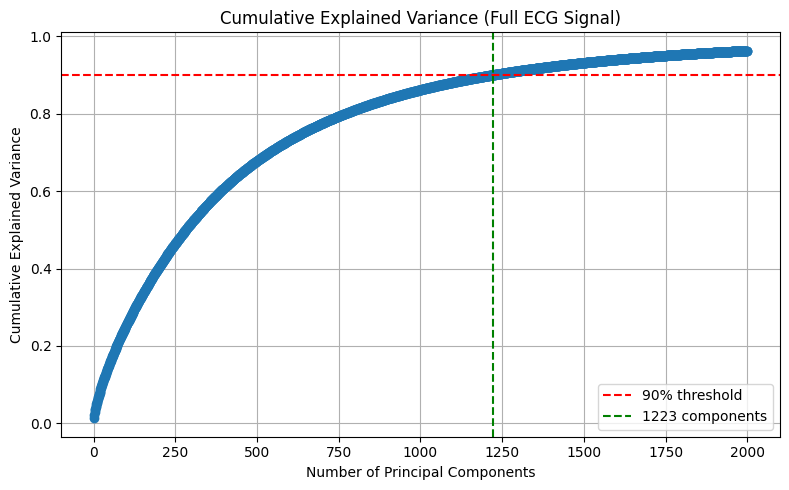

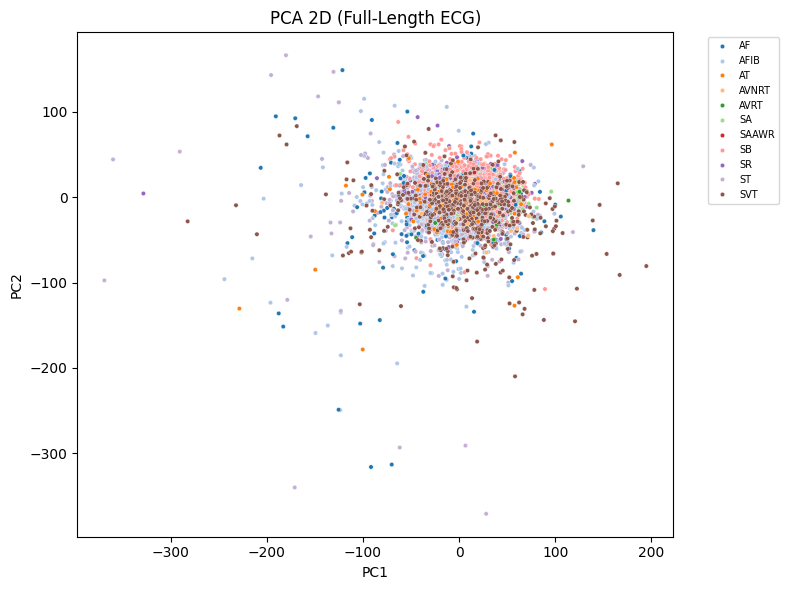

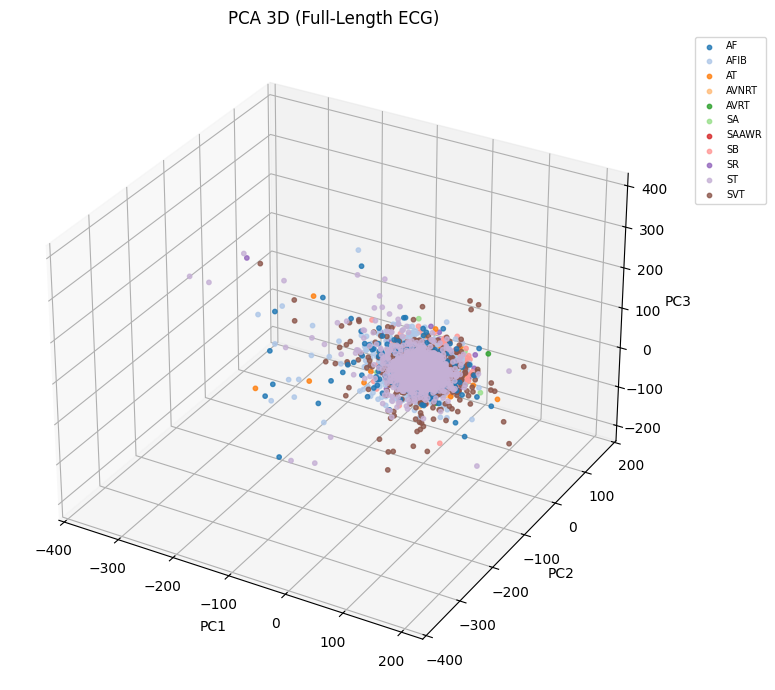

In [ ]:
# Paths
diagnostics_file = "drive/MyDrive/Diagnostics.csv"
ecg_folder       = "drive/MyDrive/ECGDataDenoisedDownloaded"
out_dir          = "drive/MyDrive/pca_plots_ECG"
os.makedirs(out_dir, exist_ok=True)

MAX_SAMPLES  = 15000
N_COMPONENTS = 2000

# Load all metadata
meta = pd.read_csv(diagnostics_file)[["FileName", "Rhythm"]]
if len(meta) > MAX_SAMPLES:
    meta = meta.sample(MAX_SAMPLES, random_state=0).reset_index(drop=True)

print(f"Loading {len(meta)} ECG segments at full resolution (12×5000) …")

# Load ECG signals
signals, labels = [], []

for _, row in meta.iterrows():
    path = os.path.join(ecg_folder, f"{row.FileName}.csv")
    if not os.path.exists(path):
        print(f"Skipping missing file: {path}")
        continue
    sig = pd.read_csv(path, header=None).values.T  # [12, 5000]
    signals.append(sig.reshape(-1))                # flatten to [60000]
    labels.append(row.Rhythm)

X = np.vstack(signals)                             # [N, 60000]
labels = np.array(labels)                          # [N]
print("Data matrix:", X.shape)

# Rhythm color mapping
rhythm_order = sorted(np.unique(labels))
color_palette = plt.cm.tab20.colors
color_map = dict(zip(rhythm_order, color_palette))

# Standardize
X = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=N_COMPONENTS, random_state=0)
X_pca = pca.fit_transform(X)
explained = pca.explained_variance_ratio_
print("Explained variance ratio (first 3):", explained[:3])

# How many components explain 90%?
cumulative = np.cumsum(explained)
n_needed = np.argmax(cumulative >= 0.90) + 1
print(f"Number of components to reach 5% explained variance: {n_needed}")

# Cumulative Variance Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, N_COMPONENTS + 1), cumulative, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label="90% threshold")
plt.axvline(n_needed, color='g', linestyle='--', label=f"{n_needed} components")
plt.title("Cumulative Explained Variance (Full ECG Signal)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pca_cumulative_variance.png"), dpi=300)
plt.show()

# 2D PCA Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=labels,
    hue_order=rhythm_order,
    palette=color_map,
    s=10
)
plt.title("PCA 2D (Full-Length ECG)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pca_2d_full.png"), dpi=300)
plt.show()

# 3D PCA Plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

for rhythm in rhythm_order:
    idx = labels == rhythm
    ax.scatter(
    X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2],
    s=10, label=rhythm, color=color_map[rhythm], alpha=0.8
)

ax.set_title("PCA 3D (Full-Length ECG)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pca_3d_full.png"), dpi=300)
plt.show()


**Side-by-Side ECG Overlay: Multi-Lead Comparison Between SB and SVT Rhythm Classes**

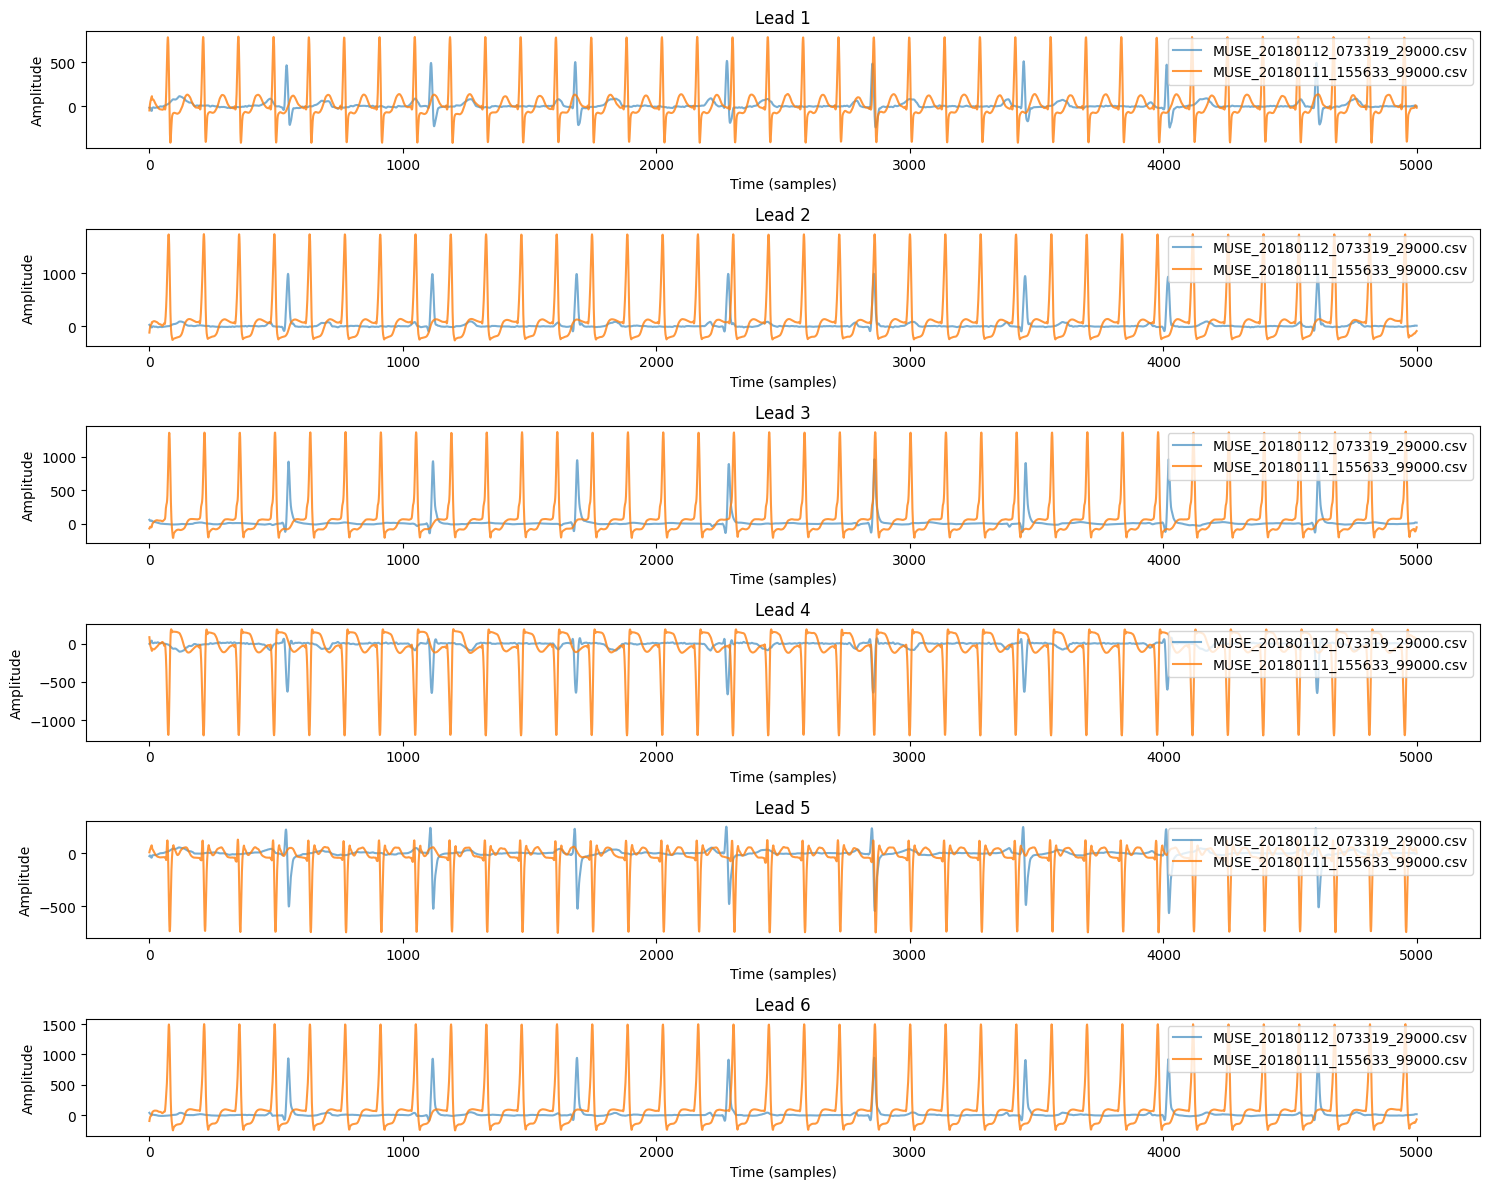

In [ ]:
def plot_two_ecgs(
    filename1,
    filename2,
    ecg_dir="drive/MyDrive/ECGDataDenoisedDownloaded",
    leads=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
):
    """
    Plot and compare two different ECG files on the same axes, for selected leads.

    Args:
        filename1 (str): First ECG file name (e.g., 'MUSE_20180111_155115_19000.csv')
        filename2 (str): Second ECG file name
        ecg_dir (str): Path to folder containing ECG CSVs
        leads (list): List of integer lead indices (0-11)
    """
    # Load files
    path1 = os.path.join(ecg_dir, filename1)
    path2 = os.path.join(ecg_dir, filename2)

    # Read ECG1
    ecg1 = pd.read_csv(path1, header=None)
    # Remove first row if it contains metadata or headers

    ecg1 = ecg1.apply(pd.to_numeric, errors='coerce')

    # Read ECG2
    ecg2 = pd.read_csv(path2, header=None)
    # Remove first row if it contains metadata or headers

    ecg2 = ecg2.apply(pd.to_numeric, errors='coerce')

    # Time axis (assuming 5000 samples)
    t = range(5000)

    # Plot
    plt.figure(figsize=(15, len(leads) * 2))
    for i, lead in enumerate(leads):
        plt.subplot(len(leads), 1, i + 1)
        plt.plot(t, ecg1[lead], label=f"{filename1}", alpha=0.6)
        plt.plot(t, ecg2[lead], label=f"{filename2}", alpha=0.8)
        plt.title(f"Lead {lead + 1}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_two_ecgs(
    filename1="MUSE_20180112_073319_29000.csv",
    filename2="MUSE_20180111_155633_99000.csv",
    leads=[0, 1, 2, 3, 4, 5]
)
